# 深層学習で数字認識 AI

## １ 目的

人工知能ライブラリ Keras で MNIST データを学習させ、手書き数字を認識できる人工知能（モデル）を作る。

## ２ 準備

### プログラム・セットアップ

このプログラムは主に Keras.io の [MNIST 手書き数字データベースを利用する数字認識モデルを学習する例](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py) に基づいたものである。

* [Keras](https://keras.io/) Python の深層学習ライブラリ
   * [日本語版のドキュメンテーショんはこちら](https://keras.io/ja/)
* Keras の利用するテンソル計算ライブラリ [TensorFlow](https://www.tensorflow.org/) (ニューラルネットワーク)
* [Python](https://www.python.jp/pages/about.html) プログラミング言語
* [Jupyter](https://jupyter.org/) ブラウザーでのプログラム実行環境
* [NumPy](https://ja.wikipedia.org/wiki/NumPy) プログラミング言語 Python における数値計算ライブラリ
* [Matplotlib](https://ja.wikipedia.org/wiki/Matplotlib) プログラミング言語 Python およびその科学計算用ライブラリ NumPy のためのグラフ描画ライブラリ

In [1]:
%matplotlib notebook

import keras
import numpy as np
import os
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import backend as K

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 
                               'Yu Gothic', 
                               'Meirio', 
                               'Takao', 
                               'IPAexGothic', 
                               'IPAPGothic', 
                               'VL PGothic', 
                               'Noto Sans CJK JP']

Using TensorFlow backend.


### データを準備

1. データを取得して、プログラムに読み込む
   * [MNIST 手書き数字データベース](https://keras.io/ja/datasets/#mnist)
      * 60,000枚の28x28，10個の数字の白黒画像と10,000枚のテスト用画像データセット
1. 使用データを分けておく
   * *training*: モデル構築時に使うデータ
   * *validation*: 検証用データ
   * *test*: 試験用データ

In [2]:
# 乱数ジェネレーターをシード
np.random.seed(1234)

num_test_samples_per_class = 20

# training と validate データをロード
(x_train, y_train), (_x_validate, _y_validate) = mnist.load_data()

# validate データをさらに validate / test に分ける
_test_ids = []
for c in [0,1,2,3,4,5,6,7,8,9]:
    _idx = np.random.choice(np.where(_y_validate==c)[0], 
                           size=(num_test_samples_per_class,),
                           replace=False)
    _test_ids.extend(_idx)

# create index masks for validation- and test-sets
_test = np.zeros(_x_validate.shape[0], dtype=bool)
_test[_test_ids] = True
_validate = ~_test

x_validate = _x_validate[_validate, :, :]
y_validate = _y_validate[_validate]

x_test = _x_validate[_test, :, :]
y_test = _y_validate[_test]

### MNIST 手書数字データとは？

<IPython.core.display.Javascript object>


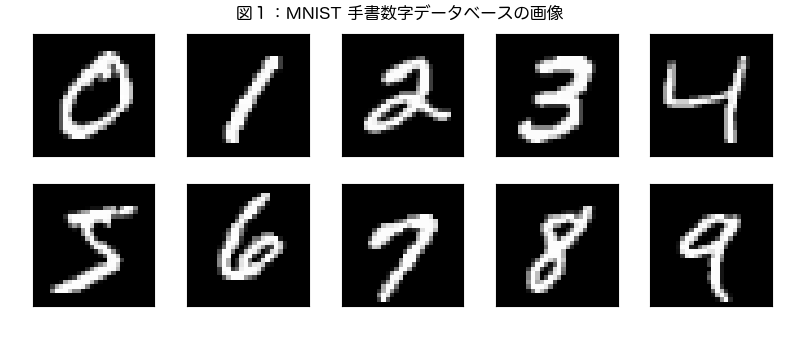

In [3]:
fig, ((ax0, ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8, ax9)) = plt.subplots(2, 5, figsize=(8,3.4))

for i,ax in enumerate([ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9]):
    idx = np.where(y_train[0:20]==i)[0][0]
    ax.imshow(x_train[idx], cmap='gray')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.subplots_adjust(top=0.91)
plt.tight_layout(pad=2.0)
#plt.subplots_tool()
plt.suptitle('図１：MNIST 手書数字データベースの画像')
plt.show()

## Reshape data

In [4]:
batch_size = 128
num_classes = 10

img_rows, img_cols = 28, 28

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_validate = x_validate.reshape(x_validate.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_validate = x_validate.reshape(x_validate.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [ ]:
x_train = x_train.astype('float32')
x_validate = x_validate.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_validate /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validate.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

In [5]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validate = keras.utils.to_categorical(y_validate, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

----

## 3. Create experimental models (3)

In [6]:
models = []
epochs = [12, 24, 12]

### model1: 8-layer CNN, 12 epochs

c.f. https://keras.io/examples/mnist_cnn/}

In [7]:
model1 = Sequential()
model1.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model1.add(Conv2D(64, (3, 3), activation='relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(Dropout(0.25))
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.Adadelta(),
               metrics=['accuracy'])

print(model1.summary())

models.append(model1)

W0819 22:41:16.806665 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0819 22:41:16.821203 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0819 22:41:16.824046 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0819 22:41:16.853189 140735751172992 deprecation_wrapper.py:119] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is d

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

### model2: 8-layer CNN (clone of model1), but trained over 24 epochs

In [8]:
model2 = keras.models.clone_model(model1)

model2.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.Adadelta(),
               metrics=['accuracy'])

print(model2.summary())

models.append(model2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

### model3: 15-layer CNN, 12 epochs

c.f. https://www.kaggle.com/adityaecdrid/mnist-with-keras-for-beginners-99457

In [9]:
model3 = Sequential()
model3.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu',
                  input_shape=input_shape))
model3.add(Conv2D(32, kernel_size=(3, 3),
                  activation='relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Conv2D(64, (3, 3), 
                  activation='relu',
                  padding='same'))
model3.add(Conv2D(64, (3, 3), 
                  activation='relu',
                  padding='same'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(Dropout(0.25))
model3.add(Conv2D(128, (3, 3), 
                  activation='relu',
                  padding='same'))
model3.add(Dropout(0.25))
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(BatchNormalization())
model3.add(Dropout(0.25))
model3.add(Dense(num_classes, activation='softmax'))

model3.compile(loss=keras.losses.categorical_crossentropy,
               optimizer=keras.optimizers.Adadelta(),
               metrics=['accuracy'])

print(model3.summary())

models.append(model3)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 6, 6, 64)          0         
__________

In [10]:
histories = []

for model, num_epochs in zip(models, epochs):
    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        shuffle=True,
                        verbose=1,
                        validation_data=(x_validate, y_validate))
    score = model.evaluate(x_validate, y_validate, verbose=0)
    print('validation loss: {:.5F}, validation accuracy: {:.5F}'.format(*score))
    print('------------------')

W0819 22:41:21.412385 140735751172992 deprecation.py:323] From /Users/brooke/anaconda3/envs/nextgen/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 60000 samples, validate on 9800 samples
Epoch 1/12
60000/60000 [==============================] - 62s 1ms/step - loss: 2.0260 - acc: 0.8163 - val_loss: 0.0781 - val_acc: 0.9769
Epoch 2/12
60000/60000 [==============================] - 61s 1ms/step - loss: 0.1211 - acc: 0.9655 - val_loss: 0.0566 - val_acc: 0.9815
Epoch 3/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0899 - acc: 0.9740 - val_loss: 0.0547 - val_acc: 0.9828
Epoch 4/12
60000/60000 [==============================] - 62s 1ms/step - loss: 0.0718 - acc: 0.9792 - val_loss: 0.0438 - val_acc: 0.9867
Epoch 5/12
60000/60000 [==============================] - 61s 1ms/step - loss: 0.0621 - acc: 0.9809 - val_loss: 0.0453 - val_acc: 0.9854
Epoch 6/12
60000/60000 [==============================] - 61s 1ms/step - loss: 0.0526 - acc: 0.9846 - val_loss: 0.0427 - val_acc: 0.9864
Epoch 7/12
60000/60000 [==============================] - 61s 1ms/step - loss: 0.0461 - acc: 0.9858 - val_loss: 0.0415 - val_acc:

In [11]:
model1.save('model1.h5')
model2.save('model2.h5')
model3.save('model3.h5')

In [ ]:
import IPython
from keras.utils import plot_model
plot_model(model, to_file='my_model.png')

IPython.display.Image('my_model.png')

In [ ]:
model.save('my_model.h5')

## TEST

In [ ]:
model.predict_classes(x_test)

In [ ]:
np.where(y_test==1)[1]

In [ ]:
_, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(8,5))

# graph for training & validation accuracy values
ax1.plot(history.history['acc'])
ax1.plot(history.history['val_acc'])

ax1.set_title(r'Model accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_xlim(0,epochs-1)
ax1.xaxis.set_major_locator(plt.MultipleLocator(1))
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number: int(value+1)))
ax1.legend(['Train', 'Test'], loc='center right', fontsize=8)
ax1.set_facecolor('0.98')
ax1.grid(alpha=0.4, zorder=1)

# graph for training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])

ax2.set_title('Model loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_xlim(0,epochs-1)
ax2.xaxis.set_major_locator(plt.MultipleLocator(1))
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda value,tick_number: int(value+1)))
ax2.legend(['Train', 'Test'], loc='center right', fontsize=8)
ax2.set_facecolor('0.98')
ax2.grid(alpha=0.4, zorder=1)

plt.suptitle(r'Accuracy & Loss in Training')
plt.tight_layout(pad=3)
plt.show()

In [ ]:
x_test[0].reshape((28,28)).flatten().shape

In [ ]:
_, ((ax0, ax1, ax2, ax3)) = plt.subplots(1, 4, figsize=(8,3.4))

for i,ax in enumerate([ax0, ax1, ax2, ax3]):
    ax.imshow(x_test[i].reshape((28,28)), cmap='gray')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

plt.subplots_adjust(top=0.91)
plt.tight_layout(pad=2.0)
#plt.subplots_tool()
#plt.suptitle('図：MNIST 手書数字データベースの画像')
plt.show()